In [1]:
!git clone https://github.com/harshadgavali/gcnattack

fatal: destination path 'gcnattack' already exists and is not an empty directory.


In [0]:
import sys
sys.path.insert(0, './gcnattack')
#sys.path

In [0]:
import time
import argparse

import torch
import numpy as np

from utils import load_data

from gcn.train import get_model, test, normalize_adj

In [0]:
from defense import defense as defense
from attack import attack as attack

In [0]:
%load_ext autoreload
%autoreload 2

In [6]:
args = argparse.Namespace(dropout=0.5, epochs=100, 
                fastmode=False, hidden=16, lr=0.01, 
                seed=42, weight_decay=0.0005,
                use_gpu=True, verbose=False,
                defense_alpha=0.2, division_delta=1e-8,
                m=2, attack_delta=0.01, attack_delta_degree=False, attack_simil_alpha=True)
args.use_gpu = args.use_gpu and torch.cuda.is_available()
print(args)

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.use_gpu:
    torch.cuda.manual_seed(args.seed)

idxs = {
    'train': torch.LongTensor(range(0, 270)), 
    'val': torch.LongTensor(range(270, 550)), 
    'test': torch.LongTensor(550+np.random.choice(1000, size=100, replace=False))
}

Namespace(attack_delta=0.01, attack_delta_degree=False, attack_simil_alpha=True, defense_alpha=0.2, division_delta=1e-08, dropout=0.5, epochs=100, fastmode=False, hidden=16, lr=0.01, m=2, seed=42, use_gpu=True, verbose=False, weight_decay=0.0005)


In [7]:
# Load data
adj, features, labels = load_data('./gcnattack/data/cora/')
if args.use_gpu:
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    for key in idxs:
        idxs[key] = idxs[key].cuda()

args.attack_delta = int(args.attack_delta * adj.shape[0])

Loading cora dataset...


In [0]:
def transform_attack(model, adj, features):
  t_total = time.time()
  for i, node in enumerate(idxs['test'].cpu().numpy()):
    t_total = time.time()
    print(i, "of", list(idxs['test'].size()), end=" ")
    if args.attack_delta_degree:
      args.attack_delta = adj[node].sum()
    adj, features = attack(model, adj, features, labels, node, args)
    print("time =", time.time() - t_total)
  return adj, features

In [0]:
adj_t = None

In [0]:
def train_attack_defense(adj, features, use_defense=False, use_attack=False):
    global adj_t
    # load params

    t_total = time.time()
    model, _ = get_model(adj, features, labels, idxs, args)
    print("Optimization Finished!")
    # print("Total time elapsed: {:.4f}s".format(time.time() - t_total), flush=True)

    # Testing
    if use_attack:
        adj_t, features = transform_attack(model, adj, features)
        
        print("Before defense")
        adj_norm = normalize_adj(adj_t, args)
        _ = test(model, adj_norm, features, labels, idxs, args)
        
        if use_defense:
            print("After defense")
            adj, features = defense(adj_t, features, args)
            adj_norm = normalize_adj(adj, args)
            _ = test(model, adj_norm, features, labels, idxs, args)
        # print("Total time elapsed: {:.4f}s".format(time.time() - t_total), flush=True)


In [11]:
train_attack_defense(adj, features, use_defense=True, use_attack=True)

Test set results: loss= 0.3879 accuracy= 0.8800
Optimization Finished!
0 of [100] time = 28.742353677749634
1 of [100] time = 28.8610782623291
2 of [100] time = 28.4959077835083
3 of [100] time = 28.381805419921875
4 of [100] time = 28.849254369735718
5 of [100] time = 28.445446968078613
6 of [100] time = 28.63227653503418
7 of [100] time = 28.524670124053955
8 of [100] time = 28.47174620628357
9 of [100] time = 28.349745988845825
10 of [100] time = 28.59738564491272
11 of [100] time = 28.485706567764282
12 of [100] time = 28.90358328819275
13 of [100] time = 28.653353691101074
14 of [100] time = 28.47193932533264
15 of [100] time = 28.264161825180054
16 of [100] time = 28.156925201416016
17 of [100] time = 28.19221591949463
18 of [100] time = 29.01205539703369
19 of [100] time = 28.486573457717896
20 of [100] time = 28.65532374382019
21 of [100] time = 28.621751070022583
22 of [100] time = 28.711963653564453
23 of [100] time = 29.090047121047974
24 of [100] time = 28.47458791732788
25

In [0]:
def get_simil_hist(adj):
  adj = adj + (adj.T - adj) * (adj.T > adj)
  adj_f = adj.float()

  M11 = torch.matmul(adj_f, adj_f.T)
  M01 = torch.matmul(adj_f, 1-adj_f.T)
  M10 = torch.matmul(1-adj_f, adj_f.T)
  simil = M11 / (M10 + M01 + M11 + args.division_delta)

  return simil[torch.tril(adj, -1).bool()]

In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Change following cell

use adj, adj_t in line 4 to get different histogram

### change cell no 4

change cell 4 to use different method of attack/defense

In [0]:
# model, _ = get_model(adj, features, labels, idxs, args)
# adj_t, _ = transform_attack(model, adj, features)

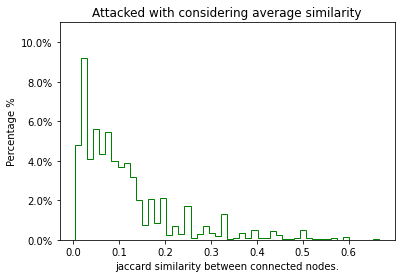

In [22]:
data = get_simil_hist(adj_t).cpu().detach().numpy()

data_nz = data[data.nonzero()[0]]

plt.hist(data_nz, weights=np.ones(len(data_nz)) / len(data), bins=50, histtype='step', color='green')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Attacked with considering average similarity")
plt.ylabel("Percentage %")
plt.ylim(0, 0.11)
plt.xlabel("jaccard similarity between connected nodes.")
plt.savefig("fig_attacked2.png")
plt.show()

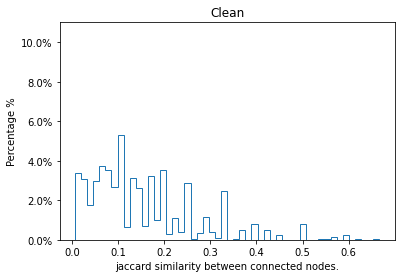

In [21]:

data = get_simil_hist(adj).cpu().detach().numpy()

data_nz = data[data.nonzero()[0]]

plt.hist(data_nz, weights=np.ones(len(data_nz)) / len(data), bins=50, histtype='step')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Clean")
plt.ylabel("Percentage %")
plt.ylim(0, 0.11)
plt.xlabel("jaccard similarity between connected nodes.")
plt.savefig("fig_clean.png")
plt.show()